# CS5242 Image & Text Data Scraping Showcase
For Neural Networks and Deep Learning (CS 5242) AY 2022-2023 Sem 1.

## Purpose of this Document
- One of the project goals is to foster practical skills with *data* acquisition, exploration, exploitation, and analysis.
- You are expected to collect and prepare a small image or text dataset based on your project topic.
- Other data forms (audio, music, etc.) are also allowed, but we suggest at least some involvement with image or text, as these are what we've been focusing on in our course.
- The dataset must be new and collected by yourself (i.e. not directly downloaded from e.g. Kaggle or GitHub).
- If you get stuck at the data collection step, this document will provide you with some hint.
- Project report should be delivered in *Jupyter notebook* with texts, figures, equations, and executable codes, just like the way of *this* very document.

## Prerequistes
1. Form you group ($\leq$ 3 members) **before Sept 25 11:59pm** (last day of reading week) by filling [this google sheet](https://docs.google.com/spreadsheets/d/1kLQ8_JHGzUQRc09uR3CjlJKQ4CfF4XhGtu35MIGGrG8/edit?usp=sharing);

2. Select your project topic and submit a one-page project plan to Canvas **before Oct 9 11:59pm** (last day of week 8);

3. Now you can start acquiring data for your project.

## General Packages for data scraping and management

The code cell below imports some generally useful tools for data crawling and management. For example:
- The *requests* package allows you to send HTTP requests using Python, i.e., you can use *requests* to download files given the file link;
- The *pandas* help you store relevant information (file directory, label, etc.) in a csv or excel document;
- The *tqdm* visualizes the progress and estimated remaining time of your data processing.

Now, run the following cell by hitting `SHIFT+ENTER` to import these packages.

In [1]:
import os
import time
import requests
import pandas as pd
from tqdm import tqdm

## Showcase 1: Image Data Collection Using Off-the-Shelf API

Many web plartforms provide API for developer use. For example, we can use Flickr API to collect image data.

Flickr is a well-known picture sharing platform, with a helpful API to facilitate developers to collect high quality image data. For this project, you may consider using the search query as the ground-truth label and collect relevant images to train a classifier for certain task. 

To use Flickr API, you need to first set up an account and apply for *authentification key* from [this link](https://www.flickr.com/services/api/misc.api_keys.html). 

Run the following cell after modifying the *key* and *secret* with your own authentification:

In [2]:
key = ''
secret = ''

### 1.1 Install Python Flickr API

Now import the python interface to Flickr API:

In [3]:
#uncomment if you have not yet installed flickrapi
#%pip install flickrapi
from flickrapi import FlickrAPI

### 1.2 Acquire Image Links

*Flickrapi* provides a *walk* function, which can walk through all photos in a set specified by a search result

In [25]:
def fetch_image_link(query):
    flickr = FlickrAPI(key, secret) #initialize python flickr api
    photos = flickr.walk(text=query,
                        tag_mode='all',
                        extras='url_c', #specify meta data to be fetched
                        sort='relevance')   #sort search result based on relevance (high to low by default)

    max_count = 10   #let's just simply fetch 5 images for illustration
    urls = []
    count = 0

    for photo in photos:
        if count < max_count:
            count = count + 1
            #print("Fetching url for image number {}".format(count))
            try:
                url = photo.get('url_c')
                urls.append(url)
            except:
                print("Url for image number {} could not be fetched".format(count))
        else:
            print(f"Done fetching {query} urls, fetched {len(urls)} urls out of {max_count}")
            break
    return urls
    
QURIES = ['cat', 'dog']    #specify search query
for query in QURIES:
    urls = fetch_image_link(query)
    print('example url:', urls[0])
    urls = pd.Series(urls)
    save_path = './Flickr_scrape/'
    if not os.path.exists(save_path):
        os.makedirs(save_path)
    category_path = f'{save_path}/{query}_urls.csv'
    print(f"Writing {query} urls to {category_path}")
    urls.to_csv(category_path)

Done fetching cat urls, fetched 10 urls out of 10
example url: https://live.staticflickr.com/4838/45925416992_c9caac8cb9_c.jpg
Writing cat urls to ./Flickr_scrape//cat_urls.csv
Done fetching dog urls, fetched 10 urls out of 10
example url: https://live.staticflickr.com/65535/5338762379_6b105a8f9b_c.jpg
Writing dog urls to ./Flickr_scrape//dog_urls.csv


### 1.3 Download files using acquired links

Till now we have collected the image urls. Now we will use the *request* package to download the image files.

In [26]:
def fetch_files_with_link(url_path):
    with open(url_path, newline="") as csvfile:
        urls = pd.read_csv(url_path, delimiter=',')
        urls = urls.iloc[:, 1].to_dict().values()
        
    SAVE_PATH = os.path.join(url_path.replace('_urls.csv', ''))
    if not os.path.isdir(SAVE_PATH):
        os.mkdir(SAVE_PATH) #define image storage path

    for idx, url in tqdm(enumerate(urls), total=len(urls)):
        # print("Starting download {} of ".format(url[0] + 1), len(urls))
        try:
            resp = requests.get(url, stream=True)   #request file using url
            path_to_write = os.path.join(SAVE_PATH, url.split("/")[-1])
            outfile = open(path_to_write, 'wb')
            outfile.write(resp.content) #save file content
            outfile.close()
            #print("Done downloading {} of {}".format(idx + 1, len(urls)))
        except:
            print("Failed to download url number {}".format(idx)) 
    print(f"Done with {url_path} download, images are saved in {SAVE_PATH}")

print("Start downloading images...")


CATEGORIES = ['cat', 'dog']    #specify search query
save_path = './Flickr_scrape/'
for category in CATEGORIES:
    url_path = f'{save_path}/{category}_urls.csv'
    fetch_files_with_link(url_path)

Start downloading images...


100%|██████████| 10/10 [00:02<00:00,  3.64it/s]


Done with ./Flickr_scrape//cat_urls.csv download, images are saved in ./Flickr_scrape//cat


100%|██████████| 10/10 [00:03<00:00,  2.55it/s]

Done with ./Flickr_scrape//dog_urls.csv download, images are saved in ./Flickr_scrape//dog


### 1.4 Visualize Collected Image Data in Notebook

You can visualize sample images in a jupyter notebook

In [27]:
import ipywidgets as widgets
from glob import glob
import numpy as np
from matplotlib import pyplot as plt
import cv2

def plot_samples(category):
    paths = sorted(glob(f'./Flickr_scrape/{category}/*.*'))
    paths = np.random.choice(paths, 4, replace=False)

    plt.figure(figsize=(12,12))
    for i in range(4):
        image = cv2.imread(paths[i])[...,[2,1,0]]
        image = cv2.resize(image, (512,512), interpolation=cv2.INTER_LINEAR)
        plt.subplot(1, 4, i+1)
        plt.imshow(image)
        plt.axis('off')
    plt.tight_layout()
    plt.show()

all_categories = ['cat', 'dog']
widgets.interact_manual.opts['manual_name'] = 'Show samples'
im = widgets.interact_manual(lambda category: plot_samples(category), category=all_categories)

interactive(children=(Dropdown(description='category', options=('cat', 'dog'), value='cat'), Button(descriptio…

### 1.5 Data Exploration, Exploitation, and Analysis

Upon acquiring your data set, you should do some statistical analysis to better understand some data property. This can be helpful to data pre-processing and can guide your next move. For example, you can visualze the distribution of image size and ratio, which can help you later design shapes of model architecture as well as find and remove images with extreme ratios. You are encouraged to come up with more strategies to explore/exploit/analyze your own acquired data.

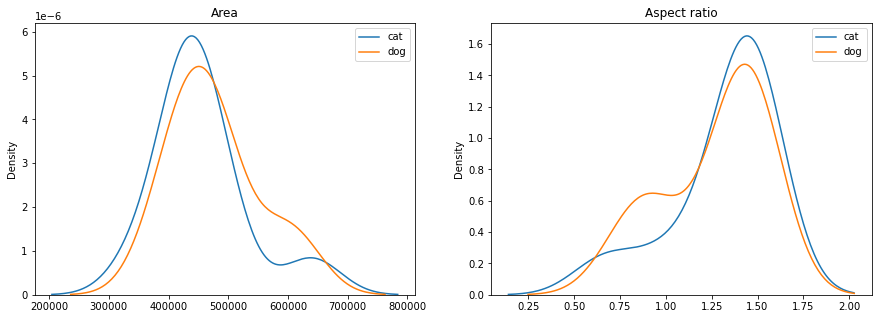

In [28]:
import seaborn as sns

def get_size(path):
    image = cv2.imread(path)
    shape = image.shape[:2]

    return shape[1]*shape[0], shape[1]/shape[0]
  
all_species = ['cat', 'dog']
sizes = []
ratios = []
fig, (ax0, ax1) = plt.subplots(1, 2, figsize=(15,5))
for i, species in enumerate(all_species):
    paths = sorted(glob(f'Flickr_scrape/{species}/*.*'))
    output = np.array([get_size(path) for path in paths])
      
    sizes.append(output[:,0])
    ratios.append(output[:,1])

    sns.kdeplot(output[:,0], label = species, ax=ax0)
    sns.kdeplot(output[:,1], label = species, ax=ax1)

ax0.set_title('Area')
ax1.set_title('Aspect ratio')
ax0.legend()
ax1.legend()
plt.show()

### 1.6 Other Potentially Useful APIs

We hope this document to help you know what to do in case you get stuch with the very first step. In the meanwhile, we hope this document won't bind your mind. Please feel free to explore other helpful APIs for the need of your own project! 

- [Twitter](https://www.tweepy.org/)
- [Facebook](https://developers.facebook.com/docs/graph-api)
- [Youtube](https://developers.google.com/youtube/v3)
- [Wikipedia](https://www.mediawiki.org/wiki/API:Main_page)
- [Spotify](https://developer.spotify.com/documentation/web-api/)
- $\cdots$

## Showcase 2: Text Data Collection Using Self-Defined Scraper

In case that your expected data is on the fly on the Internet and there is not a convenient API to collect them, then you can consider using [*selenium.webdriver*](https://www.selenium.dev/documentation/webdriver/) to develop your own data scraper. Similar packages include [*beutiful soup*](https://www.crummy.com/software/BeautifulSoup/bs4/doc/). Here we introduce *selenium.webdriver* because it renders an intuitive auto-browsing pipeline for automatic data scraping. Note that *selenium.webdriver* can be flexibly applied to scrape all kinds of data (image, text, audio, etc.). Here we use it for text data scraping just for illustration.

### 2.1 Install

To use selenium.webdriver, you can install by `pip install selenium`. Apart from that, you also need to download [*chrome web driver*](https://chromedriver.chromium.org/downloads) and put it to the directory of your notebook.

In [29]:
#uncomment if you have not yet installed selenium
#%pip install selenium
from selenium import webdriver

### 2.2 How it works

The idea of *selenium.webdriver* is to automatically open Chrome, locate html elements (e.g., buttons, searching bar) and click them to load target web pages, and then collect data (text, file links, etc.) on that page. It is like a virtual labourer who does the hard work (browsing and clicking) for you.

In the first step, you will need to browse your target page by yourself and find the *id* or *class name* of necessary html elements on that page. In Chrome, you can do this by right clicking on your target element and select `inspect`. Then you will see the html codes on a pop-up panel, from which you can locate the element in interest and fetch its *id*. You will then write code and send this *id* to selenium to let it help you collect more.

### 2.3 Hands On

The following is an example of using *Selenium.webdriver*. This code opens the Chrome browser automatically and repeatedly load random Wikipedia pages and scrape all the text contents on that page. Using these text data, you can train a language model in a self-supervised way while no label is needed. 

In the following code, some keyword, such as `n-randompage`, is html element *id* defined by this very webpage, and can vary from one web to another. You will need to find and specify new element *id* according to your own target website.

In [37]:
from selenium import webdriver
from selenium.webdriver.common.keys import Keys

WEB_TO_CRAWL = "https://en.wikipedia.org/wiki/Main_Page"
driver = webdriver.Chrome() #luanch chrome
driver.get(WEB_TO_CRAWL)    #load to your target webpage

text_collection = []

n_random_pages = 2
for _ in range(n_random_pages):
    button_to_get_random_article = driver.find_element('id', 'n-randompage')  #find 'random article' button
    button_to_get_random_article.click()    #click 'random article' button
    time.sleep(5)   #let's give Chrome a few seconds to respond

    paragraps = driver.find_elements('tag name', 'p')   #find text elements. In http, text elements commonly have 'p' as tag name. Similarly, images commonly have 'img' as tag name.
    for para in paragraps:
        text = para.get_attribute("innerText")  #get text content from the element object
        import re
        text = re.sub('[\(\[].*?[\)\]]', '', text)  #remove substrings in () and []. You can do other necessary pre-processing using regular expression syntax.
        text = newlabel = re.sub('[^A-Za-z0-9\.\,]+', ' ', text)  #keep only alphabetic letters, numbers, and dot and comma.
        text_collection.append(text + '\n')

driver.close()  #close Chrome

with open('./selenium_scrap_text.txt', 'w') as f:
    f.writelines(text_collection)



### 2.4 Tips
- It is recommended to only crawl *open-source* data using this method ('open-source' data is what you can get without log-in or commercial subscription).
- Certain webpage may have anti-crawl settings. It might help to put a `time.sleep(5)` between consecutive operations.

One last note is that, your project delivery includes an 8-minute **presentation** (with slides) and a **report**. The report should be formated in *Jupyter notebook* with texts, figures, equations, and executable codes, **just like the way of *this* very document**. You may find [this Markdown cheatsheet](https://github.com/adam-p/markdown-here/wiki/Markdown-Cheatsheet) helpful. The output of each code cell should be kept there (do not clear them) when submitting your notebook report.

Best luck with your project! (ง •̀_•́)ง

Jingwei

Sept 16, 2022